In [5]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteo_api import MeteoAPI
from meteo_analyzer import MeteoAnalyzer

Task 1 - MeteoAPI class

In [6]:
place_code = "kaunas"
station_code = "kauno-ams"
url = f"https://api.meteo.lt/v1/"
meteoAPI = MeteoAPI(place_code, station_code, url)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today().replace(year=datetime.today().year - 1)).strftime('%Y-%m-%d')
analyzer = MeteoAnalyzer(meteoAPI, start_date, end_date)

Task 2 - Read year of data and visualize it

In [7]:
analyzer.fetch_hist_data()
analyzer.fetch_forecast_data()

In [12]:
print(f"Mean airTemperature: {analyzer.get_hist_metric('airTemperature').mean():.2f}")
print(f"Mean relativeHumidity: {analyzer.get_hist_metric('relativeHumidity').mean():.2f}")
print(f"Mean day airTemperature: {analyzer.calculate_hist_day_mean('airTemperature'):.2f}")
print(f"Mean night airTemperature: {analyzer.calculate_hist_night_mean('airTemperature'):.2f}")
print(f"Weekends count which had rain on both days for atleast hour: {analyzer.calculate_rainy_weekends()}")

Mean airTemperature: 9.46
Mean relativeHumidity: 78.62
Mean day airTemperature: 11.09
Mean night airTemperature: 7.53
Weekends count which had rain on both days for atleast hour: 31


Task 3 - Visualize historical temperature together with forecast

In [13]:
def cut_forecast_start(hist_data, forecast):
    """Make forecast series follow one hour later than historical.
    Args:
        hist_data (pd.Series): historical data
        forecast (pd.Series): forecasted data
    Returns:
        pd.Series, with cut forecast observations from the start 
    """
    difference = hist_data.index[-1].hour - forecast.index[0].hour + 1
    if difference > 0:
        forecast = forecast.tail(-difference)
    return forecast

def plot_ts(ts_historical, ts_forecast):
    """Plot two time series with sequential DateTimeIndex
    Args:
        ts_historical (pd.Series): historical data
        ts_forecast (pd.Series): forecasted data
    """
    plt.figure(figsize=(10, 6))
    ts_historical.plot(label='Historical', color='green')
    ts_forecast.plot(label='Forecasted', color='orange', linestyle='--')
    plt.title('Historical and forecasted temperature plot')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

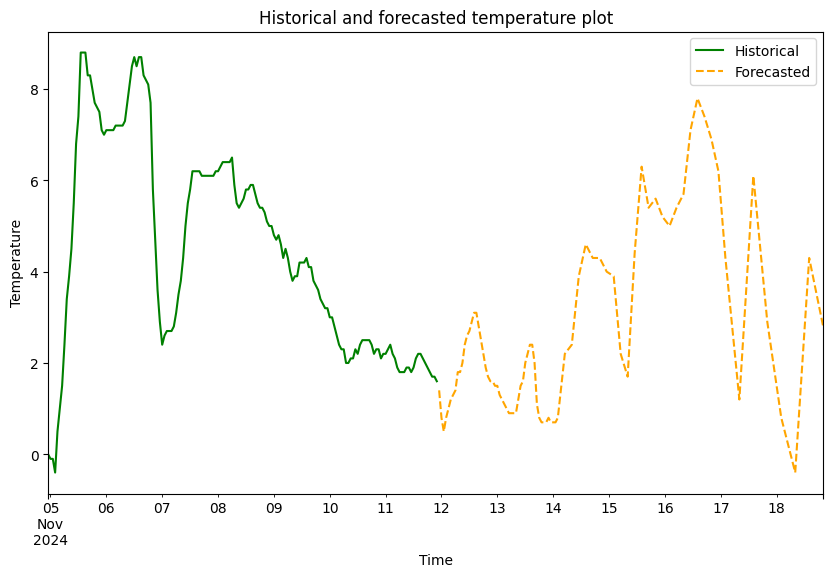

In [14]:
ts_hist = analyzer.get_hist_metric("airTemperature")
ts_forec = analyzer.get_forecast_metric("airTemperature")

last_days = 7
ts_hist_cut = ts_hist.tail(last_days * 24)
ts_forec = cut_forecast_start(ts_hist, ts_forec)
plot_ts(ts_hist_cut, ts_forec)

Task 4 - Resample and interpolate series

In [15]:
def resample_ts_to_five_min(ts):
    """Change ts frequency to 5 minutes and use linear interpolation for empty values.
    Args:
        ts (pd.Series): series to change frequency
    Returns:
        data (pd.Series): series with changed frequency
    """
    data = ts.resample('5min').mean()
    data = data.interpolate()
    return data

In [16]:
print("Before resampling:")
print(ts_hist.describe())
print("After resampling:")
ts_hist_five_min = resample_ts_to_five_min(ts_hist)
print(ts_hist_five_min.describe())

Before resampling:
count    8807.000000
mean        9.458113
std         9.320009
min       -23.200000
25%         2.000000
50%         8.800000
75%        16.950000
max        32.900000
Name: airTemperature, dtype: float64
After resampling:
count    105673.000000
mean          9.458733
std           9.310856
min         -23.200000
25%           2.016667
50%           8.800000
75%          16.975000
max          32.900000
Name: airTemperature, dtype: float64
